## Compute DCSC's TXND: the number of unusually hot days

Example notebook that runs icclim.

The example calculates the number of unusually hot days (TXND indicator from DCSC) for the dataset chosen by the user on C4I.

We assume to have the **tasmax** variable in netCDF files in a `./data` folder for model `CMCC` and for one member `r1i1p1f1`.  
The data can be dowloaded using the [metalink](data/cmcc_tas.metalink) provided with this notebook.  
The data described in a `.metalink` file can be dowloaded with tools such as [aria2](https://aria2.github.io/) or a browser plugin such as [DownThemAll!](https://addons.mozilla.org/en-US/firefox/addon/downthemall/)
If you wish to use a different dataset, you can use the [climate 4 impact portal](https://www.climate4impact.eu/c4i-frontend/) to search and select the data you wish to use and a metalink file to the [ESGF](https://esgf.llnl.gov/) data will be provided.

The data is read using xarray and a plot of the time series over a specific region is generated, as well as an average spatial map. Several output types examples are shown.

To keep this example fast to run, the following period is considered: 2015-01-01 to 2019-12-31, and plots are shown over European region.

### Installation and preparation of the needed modules

In [1]:
import datetime
import sys
from pathlib import Path

import cartopy.crs as ccrs
import cftime
import icclim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xclim
from xclim.core.calendar import select_time 
from icclim.frequency import FrequencyRegistry

print("python: ", sys.version)
print("numpy: ", np.__version__)
print("xarray: ", xr.__version__)
print("pandas: ", pd.__version__)
print("icclim: ", icclim.__version__)
print("cftime: ", cftime.__version__)
print("xclim: ", xclim.__version__)


python:  3.11.7 | packaged by conda-forge | (main, Dec 15 2023, 08:38:37) [GCC 12.3.0]
numpy:  1.26.4
xarray:  2024.2.0
pandas:  2.2.1
icclim:  7.0.0
cftime:  1.6.3
xclim:  0.48.0


### Specification of the parameters

In [2]:
DATA_DIR = Path("./data")
out_f = "txnd_icclim.nc"

In [3]:
historical_files = [str(f) for f in DATA_DIR.glob("tas*CMCC*historical*.nc")]
sorted(historical_files)

['data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_18500101-18741231.nc',
 'data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_18750101-18991231.nc',
 'data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_19000101-19241231.nc',
 'data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_19250101-19491231.nc',
 'data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_19500101-19741231.nc',
 'data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_19750101-19991231.nc',
 'data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_20000101-20141231.nc']

In [4]:
studied_files = [str(f) for f in DATA_DIR.glob("tas*CMCC*ssp585*.nc")]
sorted(studied_files)

['data/tas_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20150101-20391231.nc',
 'data/tas_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20400101-20641231.nc',
 'data/tas_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20650101-20891231.nc',
 'data/tas_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20900101-21001231.nc']

# Build NormaL

We build the summer `normal`, from April to September included.  
This normat DataArray will have one value per `lat, lon` couple, the values will be the mean of temperature of the summers within the reference periode.  
We will make use of xclim's `select_time` to filter the summer months.

> ℹ️  Alternatively, the normal can be saved in a netCDF file and the path to this file can be used in `normal` parameter of `icclim.dcsc.txnd` function.

In [5]:
historical_tas = xr.open_mfdataset(historical_files).tas
filtered_tas = select_time(historical_tas, month=FrequencyRegistry.AMJJAS.indexer["month"], drop=True)
normal = filtered_tas.mean(dim="time", keep_attrs=True)
normal

<xarray.DataArray 'tas' (lat: 192, lon: 288)> Size: 221kB
dask.array<mean_agg-aggregate, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  TREFHT
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2020-12-21T16:22:42Z altered by CMOR: Treated scalar dime...

## Compute TXND index

Usually TXND is computed on the maximum daily temperature (tasmax), but here we show that using `var_name` we can force icclim to use a different variable to compute indices, as long as its units is compatible.

In [6]:
icclim.dcsc.txnd(
    in_files=studied_files[0:1],
    normal = normal,
    var_name="tas",
    slice_mode=FrequencyRegistry.AMJJAS,
    out_file=out_f,
    logs_verbosity="SILENT",
)

/home/bzah/workspace/cerfacs/icclim/src/icclim/_core/generic/indicator.py:534: UserWarning: Unable to infer the frequency of the time series. To mute this, set xclim's option data_validation='log'.
  check_freq(da, src_freq, strict=True)
/home/bzah/micromamba/envs/icclim-dev/lib/python3.11/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/home/bzah/micromamba/envs/icclim-dev/lib/python3.11/site-packages/xclim/core/cfchecks.py:46: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


<xarray.Dataset> Size: 5MB
Dimensions:      (lat: 192, lon: 288, time: 11, bounds: 2)
Coordinates:
  * lat          (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon          (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height       float64 8B 2.0
  * time         (time) object 88B 2090-06-16 00:00:00 ... 2100-06-16 00:00:00
  * bounds       (bounds) int64 16B 0 1
Data variables:
    TXND         (time, lat, lon) float64 5MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    time_bounds  (time, bounds) object 176B 2090-04-01 00:00:00 ... 2100-08-3...
Attributes:
    title:        number_of_days_when_maximum_air_temperature_is_greater_than...
    references:   Portail DRIAS, DCSC, MeteoFrance
    institution:  Climate impact portal (https://climate4impact.eu)
    history:      2021-01-18T14:11:26Z altered by CMOR: Treated scalar dimens...
    source:       
    Conventions:  CF-1.6

### Plot settings

In [7]:
txnd_dataset = xr.open_dataset(out_f)
txnd_dataset

<xarray.Dataset> Size: 5MB
Dimensions:      (lat: 192, lon: 288, time: 11, bounds: 2)
Coordinates:
  * lat          (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon          (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height       float64 8B ...
  * time         (time) object 88B 2090-06-16 00:00:00 ... 2100-06-16 00:00:00
  * bounds       (bounds) int64 16B 0 1
Data variables:
    TXND         (time, lat, lon) float64 5MB ...
    time_bounds  (time, bounds) object 176B ...
Attributes:
    title:        number_of_days_when_maximum_air_temperature_is_greater_than...
    references:   Portail DRIAS, DCSC, MeteoFrance
    institution:  Climate impact portal (https://climate4impact.eu)
    history:      2021-01-18T14:11:26Z altered by CMOR: Treated scalar dimens...
    source:       
    Conventions:  CF-1.6

In [8]:
txnd = txnd_dataset.TXND
txnd

<xarray.DataArray 'TXND' (time: 11, lat: 192, lon: 288)> Size: 5MB
[608256 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    height   float64 8B ...
  * time     (time) object 88B 2090-06-16 00:00:00 ... 2100-06-16 00:00:00
Attributes:
    standard_name:  number_of_days_when_maximum_air_temperature_is_greater_th...
    long_name:      Number of days when maximum air temperature is greater th...
    comment:        near-surface (usually, 2 meter) air temperature
    units:          d
    original_name:  TREFHT
    cell_methods:   time: sum over days
    cell_measures:  area: areacella
    history:

In [9]:
# Select a single x,y combination from the data
longitude = txnd_dataset.TXND["lon"].sel(lon=3.5, method="nearest")
latitude = txnd_dataset.TXND["lat"].sel(lat=44.2, method="nearest")

print("Long, Lat values:", longitude, latitude)

Long, Lat values: <xarray.DataArray 'lon' ()> Size: 8B
array(3.75)
Coordinates:
    lon      float64 8B 3.75
    height   float64 8B ...
Attributes:
    bounds:         lon_bnds
    units:          degrees_east
    axis:           X
    long_name:      Longitude
    standard_name:  longitude <xarray.DataArray 'lat' ()> Size: 8B
array(43.82198953)
Coordinates:
    lat      float64 8B 43.82
    height   float64 8B ...
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      Latitude
    standard_name:  latitude


In [10]:
txnd_dataset.attrs["title"]

'number_of_days_when_maximum_air_temperature_is_greater_than_thresholds'

> ℹ️ Notice that the title is not quite right in the resulting dataset.  
> TXND assumes to be computed on tasmax, so its output title includes `maximum_air_temperature` but here we used a `air_temperature` variable.

### Subset and Plot TXND

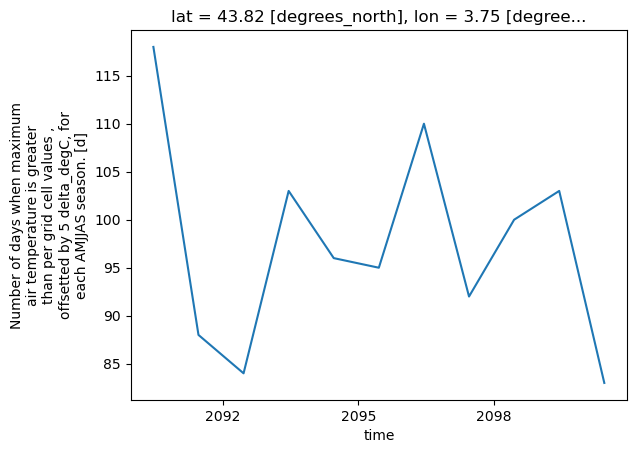

In [11]:
# Slice the data spatially using a single lat/lon point
one_point = txnd.sel(lat=latitude, lon=longitude)

# Use xarray to create a quick time series plot
one_point.plot.line()
plt.show()

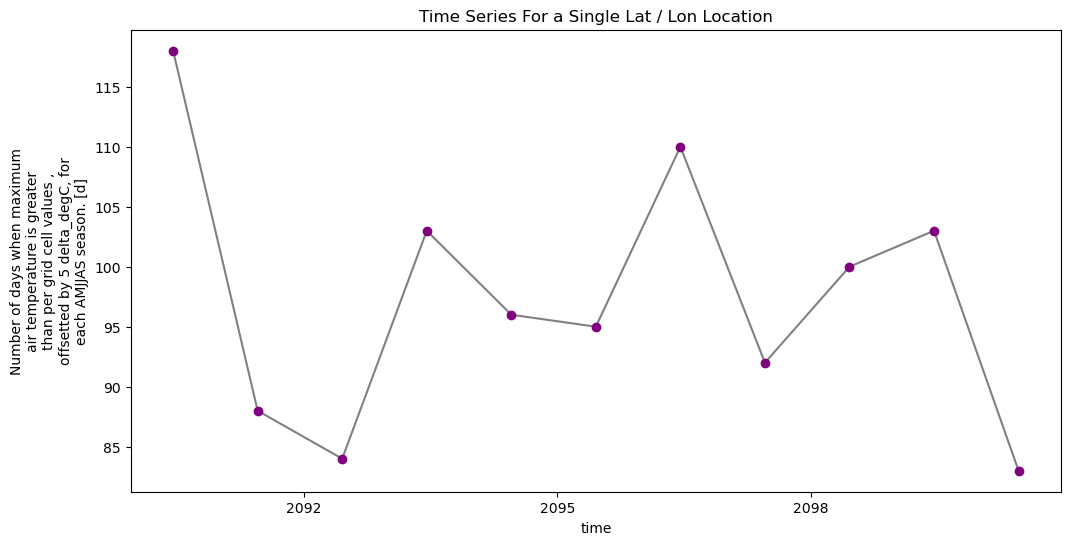

In [12]:
# You can clean up your plot as you wish using standard matplotlib approaches
f, ax = plt.subplots(figsize=(12, 6))
one_point.plot.line(
    hue="lat",
    marker="o",
    ax=ax,
    color="grey",
    markerfacecolor="purple",
    markeredgecolor="purple",
)
ax.set(title="Time Series For a Single Lat / Lon Location")

# Uncomment the line below if you wish to export the figure as a .png file
# plt.savefig("single_point_timeseries.png")
plt.show()

In [13]:
# Convert to dataframe -- then this can easily be exported to a csv
one_point_df = one_point.to_dataframe()
# View just the first 5 rows of the data
one_point_df.head()

# Export data to .csv file
# one_point_df.to_csv("one-location.csv")

,lat,lon,height,TXND
time,,,,
2090-06-16 00:00:00,43.82199,3.75,2.0,118.0
2091-06-16 00:00:00,43.82199,3.75,2.0,88.0
2092-06-16 00:00:00,43.82199,3.75,2.0,84.0
2093-06-16 00:00:00,43.82199,3.75,2.0,103.0
2094-06-16 00:00:00,43.82199,3.75,2.0,96.0


In [14]:
# Time subsetting: this is just an example on how to do it
start_date = "2050-01-01"
end_date = "2100-12-31"

txnd_filtered = txnd.sel(time=slice(start_date, end_date))

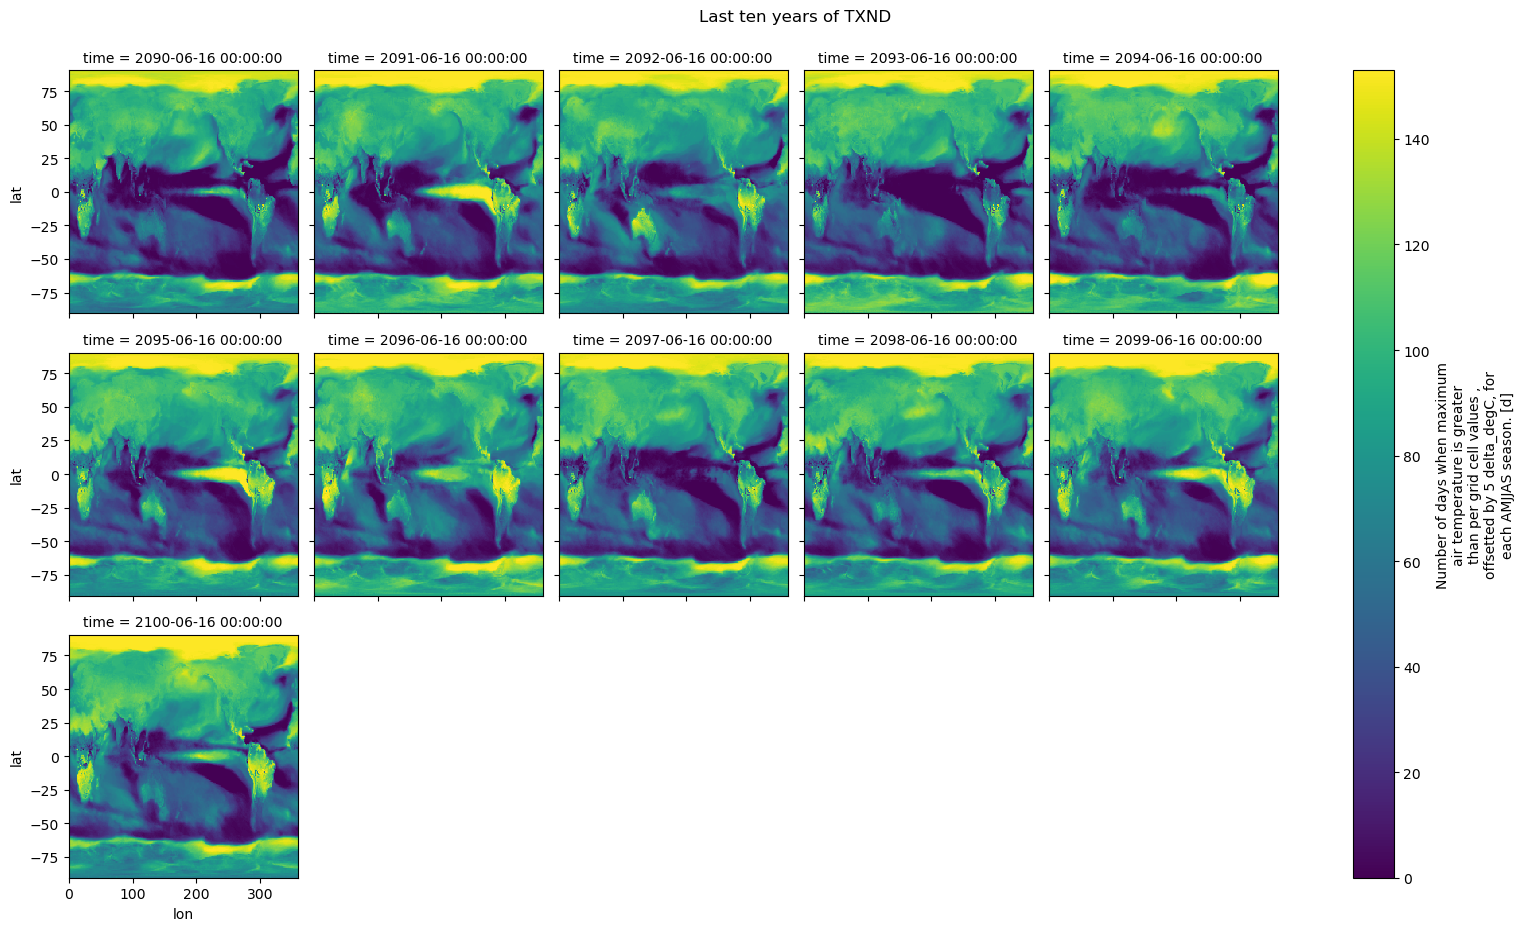

In [15]:
# Quickly plot the data using xarray.plot()
txnd_filtered.plot(x="lon", y="lat", col="time", col_wrap=5)

plt.suptitle("Last ten years of TXND", y=1.03)
plt.show()

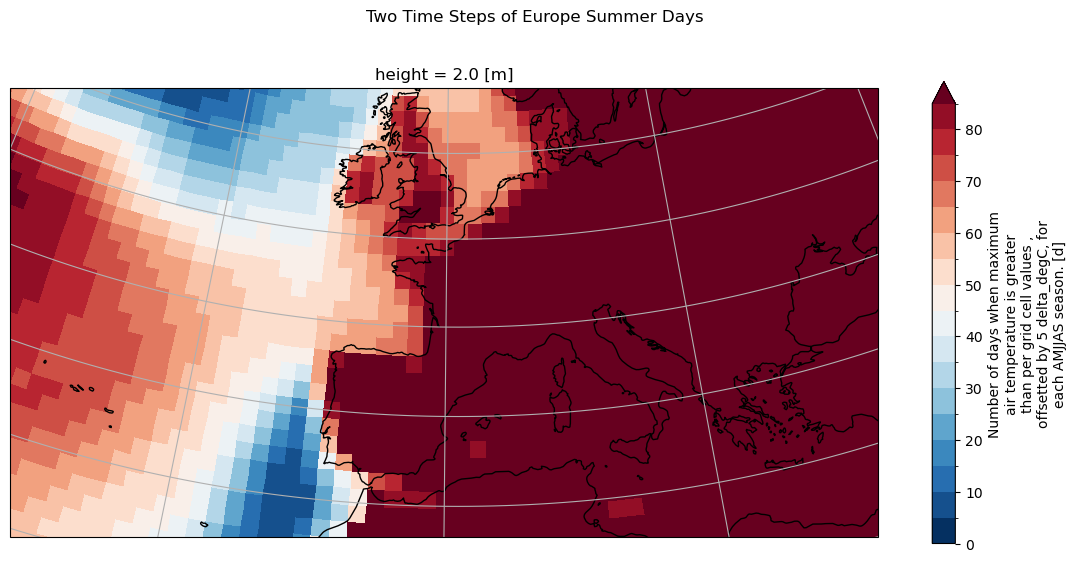

In [16]:
# Set spatial extent and centre
central_lat = 47.0
central_lon = 1.0
extent = [-30, 30, 30, 56]  # Western Europe

# Calculate time average
txnd_avg = txnd.mean(dim="time", keep_attrs=True)

# Set plot projection
map_proj = ccrs.AlbersEqualArea(
    central_longitude=central_lon, central_latitude=central_lat
)

# Define plot
f, ax = plt.subplots(figsize=(14, 6), subplot_kw={"projection": map_proj})

# Plot data with proper colormap scale range
levels = np.arange(0, 90, 5)
p = txnd_avg.plot(levels=levels, cmap="RdBu_r", transform=ccrs.PlateCarree())

# Plot information
plt.suptitle("Two Time Steps of Europe Summer Days", y=1)

# Add the coastlines to axis and set extent
ax.coastlines()
ax.gridlines()
ax.set_extent(extent)

# Save plot as png
plt.savefig("txnd_avg_icclim.png")

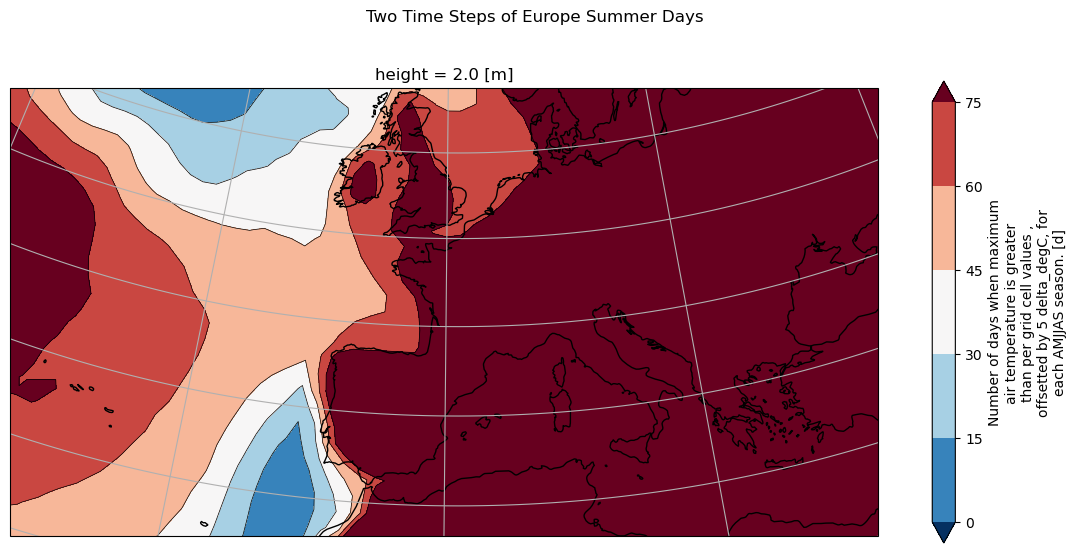

In [17]:
# Re-order longitude so that there is no blank line at 0 deg because 0 deg is within our spatial selection
txnd_avg.coords["lon"] = (txnd_avg.coords["lon"] + 180) % 360 - 180
txnd_avg = txnd_avg.sortby(txnd_avg.lon)

# Define plot
f, ax = plt.subplots(figsize=(14, 6), subplot_kw={"projection": map_proj})

# Define colorscale
levels = np.arange(0, 90, 15)

# Contours lines
p = txnd_avg.plot.contour(
    levels=levels, colors="k", linewidths=0.5, transform=ccrs.PlateCarree()
)

# Contour filled colors
p = txnd_avg.plot.contourf(
    levels=levels, cmap="RdBu_r", extend="both", transform=ccrs.PlateCarree()
)

# Plot information
plt.suptitle("Two Time Steps of Europe Summer Days", y=1)

# Add the coastlines to axis and set extent
ax.coastlines()
ax.gridlines()
ax.set_extent(extent)

# Save plot as png
plt.savefig("txnd_avg_contours_icclim.png")